## Supervised and Unsupervised Learning for Country Classification
### Dataset used: Arms import 
##### Link to download : http://data.un.org/Data.aspx?d=WDI&f=Indicator_Code%3aMS.MIL.MPRT.KD


In [1]:
#libraries for model performance evaluation
from sklearn import metrics
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,f1_score

#libraries for visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from matplotlib.colors import ListedColormap

# libraries for computation
import pandas as pd
import numpy as np

#library for train test split
from sklearn.model_selection import train_test_split,cross_val_score,KFold

#library for preprocessing
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler,MinMaxScaler

#library for Dimensionality reduction
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD

#Library for feature selection techniques
from sklearn.feature_selection import RFE

#libraries for various ML models 
from sklearn import svm
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
#ensemble models
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier

#Libraries for Unsupervised learning
from sklearn.cluster import KMeans,AgglomerativeClustering

#libraries for model performance evaluation
from sklearn import metrics
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,f1_score

#libraries for visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from matplotlib.colors import ListedColormap
from mpl_toolkits.mplot3d import Axes3D

import warnings
warnings.filterwarnings('ignore')

/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
# Utility Method to plot confusion matrix
def plotConfusionMatrix(cm):
    sns.set_style('white')
    plt.clf()
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Pastel1)
    classNames = ['Developed','Developing']
    plt.title('Confusion Matrix',fontsize = 15)
    plt.ylabel('True label',fontsize=15)
    plt.xlabel('Predicted label',fontsize=15)
    tick_marks = np.arange(len(classNames))
    plt.xticks(tick_marks, classNames,fontsize=12)
    plt.yticks(tick_marks, classNames,fontsize=12)
    s = [['TP','FN'], ['FP', 'TN']]
    for i in range(2):
        for j in range(2):
            plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
    plt.show()

### Read Data from CSV

In [3]:
# Read data from csv and print the head
data = pd.read_csv('Arms-import.csv')
data.head(5)

,Country or Area,Year,Value,Value Footnotes
0,Afghanistan,2017,250000000.0,NaN
1,Afghanistan,2016,176000000.0,NaN
2,Afghanistan,2015,116000000.0,NaN
3,Afghanistan,2014,288000000.0,NaN
4,Afghanistan,2013,235000000.0,NaN


#### lets drop extra column Value Footnotes

In [4]:
# Read data from csv and print the head
data = data.drop(columns=['Value Footnotes'])
data.head(5)

,Country or Area,Year,Value
0,Afghanistan,2017,250000000.0
1,Afghanistan,2016,176000000.0
2,Afghanistan,2015,116000000.0
3,Afghanistan,2014,288000000.0
4,Afghanistan,2013,235000000.0


#### Get data insights

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8258 entries, 0 to 8257
Data columns (total 3 columns):
Country or Area    8258 non-null object
Year               8258 non-null object
Value              8256 non-null float64
dtypes: float64(1), object(2)
memory usage: 193.6+ KB


#### It seems Value column has some null or Nan values

In [6]:
vals = data['Value']
d = data[ vals.isna() ]
d

,Country or Area,Year,Value
8256,footnoteSeqID,Footnote,NaN
8257,2,Value of deliveries is less than 0.5 million TIV,NaN


##### lets drop this rows

In [7]:
data  = data [0:8256] 
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8256 entries, 0 to 8255
Data columns (total 3 columns):
Country or Area    8256 non-null object
Year               8256 non-null object
Value              8256 non-null float64
dtypes: float64(1), object(2)
memory usage: 193.6+ KB


In [8]:
#lets check number of unique countries we have in dataset
data['Country or Area'].nunique()

232

### Lets normalize data

In [9]:
# Normalize the value column and drop old column

# Create x, where x the 'Value' column's values as floats
x = data[['Value']].values.astype(float)

# Create a minimum and maximum processor object
min_max_scaler = preprocessing.MinMaxScaler()

# Create an object to transform the data to fit minmax processor
x_scaled = min_max_scaler.fit_transform(x)

# Run the normalizer on the dataframe
df_normalized = pd.DataFrame(x_scaled)
df_normalized['normalized'] = pd.DataFrame(x_scaled)
df_normalized.drop(columns=0,inplace=True)

data_new = pd.concat([data,df_normalized ], axis=1)
data_new.drop(columns='Value',inplace=True)

In [10]:
# Check new dataframe with normalized value
data_new.head()

,Country or Area,Year,normalized
0,Afghanistan,2017,0.005994
1,Afghanistan,2016,0.004220
2,Afghanistan,2015,0.002781
3,Afghanistan,2014,0.006905
4,Afghanistan,2013,0.005634


#### Using tsfresh to extract features from data

In [11]:
# Use TSFresh library to extract features from data 
from tsfresh import extract_features
extracted_features = extract_features(data_new, column_id="Country or Area", column_sort="Year")

Feature Extraction: 100%|██████████| 10/10 [00:23<00:00,  2.09s/it]


In [12]:
#Check extracted features
extracted_features.head()

variable,normalized__abs_energy,normalized__absolute_sum_of_changes,"normalized__agg_autocorrelation__f_agg_""mean""","normalized__agg_autocorrelation__f_agg_""median""","normalized__agg_autocorrelation__f_agg_""var""","normalized__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""intercept""","normalized__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""rvalue""","normalized__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""slope""","normalized__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""stderr""","normalized__agg_linear_trend__f_agg_""max""__chunk_len_50__attr_""intercept""",...,normalized__time_reversal_asymmetry_statistic__lag_1,normalized__time_reversal_asymmetry_statistic__lag_2,normalized__time_reversal_asymmetry_statistic__lag_3,normalized__value_count__value_-inf,normalized__value_count__value_0,normalized__value_count__value_1,normalized__value_count__value_inf,normalized__value_count__value_nan,normalized__variance,normalized__variance_larger_than_standard_deviation
id,,,,,,,,,,,,,,,,,,,,,
Afghanistan,0.008196,0.177612,-0.034824,-0.060815,0.048577,0.016054,0.075831,0.000937,0.007117,NaN,...,1.541280e-07,5.190910e-07,1.163574e-06,0.0,0.0,0.0,0.0,0.0,0.000121,0.0
Albania,0.000262,0.028004,-0.060133,-0.056351,0.147890,0.008511,-0.814430,-0.003381,0.002409,NaN,...,1.656633e-10,6.605287e-11,-1.028939e-09,0.0,1.0,0.0,0.0,0.0,0.000006,0.0
Algeria,0.019031,0.391522,0.055072,0.044231,0.068417,0.018656,0.688800,0.007167,0.003772,0.045506,...,1.900281e-06,9.291907e-07,1.466092e-07,0.0,0.0,0.0,0.0,0.0,0.000179,0.0
Angola,0.002455,0.097557,-0.040989,-0.061263,0.067736,0.020283,-0.547124,-0.004388,0.004746,NaN,...,5.265793e-08,1.583488e-07,1.709011e-07,0.0,0.0,0.0,0.0,0.0,0.000039,0.0
Arab World,1.755274,1.643099,0.013193,0.039605,0.301875,0.209934,0.105092,0.006611,0.031280,0.393177,...,5.952909e-04,7.425558e-04,7.641989e-04,0.0,0.0,0.0,0.0,0.0,0.007977,0.0


In [13]:
#Check shape of new data with extracted features
extracted_features.shape

(232, 794)

In [14]:
#Check if any columns contains Nan values (null values)
list_cols_with_nan = extracted_features.columns[extracted_features.isna().any()].tolist()
len(list_cols_with_nan)

548

In [15]:
# it seems 552 columns out of 794 have some null values

In [16]:
#lets replace nan value with 0.0
from tsfresh import select_features
from tsfresh.utilities.dataframe_functions import impute
data_after_impute = impute(extracted_features)

 'normalized__fft_coefficient__coeff_30__attr_"angle"'
 'normalized__fft_coefficient__coeff_30__attr_"imag"'
 'normalized__fft_coefficient__coeff_30__attr_"real"'
 'normalized__fft_coefficient__coeff_31__attr_"abs"'
 'normalized__fft_coefficient__coeff_31__attr_"angle"'
 'normalized__fft_coefficient__coeff_31__attr_"imag"'
 'normalized__fft_coefficient__coeff_31__attr_"real"'
 'normalized__fft_coefficient__coeff_32__attr_"abs"'
 'normalized__fft_coefficient__coeff_32__attr_"angle"'
 'normalized__fft_coefficient__coeff_32__attr_"imag"'
 'normalized__fft_coefficient__coeff_32__attr_"real"'
 'normalized__fft_coefficient__coeff_33__attr_"abs"'
 'normalized__fft_coefficient__coeff_33__attr_"angle"'
 'normalized__fft_coefficient__coeff_33__attr_"imag"'
 'normalized__fft_coefficient__coeff_33__attr_"real"'
 'normalized__fft_coefficient__coeff_34__attr_"abs"'
 'normalized__fft_coefficient__coeff_34__attr_"angle"'
 'normalized__fft_coefficient__coeff_34__attr_"imag"'
 'normalized__fft_coefficie

In [17]:
#lets check if any column has any nan value
list_cols_with_nan_after_impute = data_after_impute.columns[data_after_impute.isna().any()].tolist()
len(list_cols_with_nan_after_impute)

0

In [18]:
#we dont have any nan values 
# lets reset the index
data_after_impute = data_after_impute.reset_index()

In [19]:
# we need to give labels to countries 
data_countries = pd.read_excel('Developing countries.xlsx')

developed_countries = data_countries [data_countries['Value'] == 0]
developing_countries = data_countries [data_countries['Value'] == 1] 

list_developed_countries = developed_countries['Countries']
list_developing_countries = developing_countries['Countries']

list_developed_countries = list(list_developed_countries)
list_developing_countries = list(list_developing_countries)

data_after_impute['label'] = -1

for i,da in data_after_impute.iterrows():
    if da['id'] in list_developed_countries:
        val = 0
        data_after_impute.at[i,'label'] = val
    elif da['id'] not in list_developed_countries:
        val = 1
        data_after_impute.at[i,'label'] = val

In [20]:
# check new df with added column as label 
data_after_impute.head()

variable,id,normalized__abs_energy,normalized__absolute_sum_of_changes,"normalized__agg_autocorrelation__f_agg_""mean""","normalized__agg_autocorrelation__f_agg_""median""","normalized__agg_autocorrelation__f_agg_""var""","normalized__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""intercept""","normalized__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""rvalue""","normalized__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""slope""","normalized__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""stderr""",...,normalized__time_reversal_asymmetry_statistic__lag_2,normalized__time_reversal_asymmetry_statistic__lag_3,normalized__value_count__value_-inf,normalized__value_count__value_0,normalized__value_count__value_1,normalized__value_count__value_inf,normalized__value_count__value_nan,normalized__variance,normalized__variance_larger_than_standard_deviation,label
0,Afghanistan,0.008196,0.177612,-0.034824,-0.060815,0.048577,0.016054,0.075831,0.000937,0.007117,...,5.190910e-07,1.163574e-06,0.0,0.0,0.0,0.0,0.0,0.000121,0.0,1
1,Albania,0.000262,0.028004,-0.060133,-0.056351,0.147890,0.008511,-0.814430,-0.003381,0.002409,...,6.605287e-11,-1.028939e-09,0.0,1.0,0.0,0.0,0.0,0.000006,0.0,1
2,Algeria,0.019031,0.391522,0.055072,0.044231,0.068417,0.018656,0.688800,0.007167,0.003772,...,9.291907e-07,1.466092e-07,0.0,0.0,0.0,0.0,0.0,0.000179,0.0,1
3,Angola,0.002455,0.097557,-0.040989,-0.061263,0.067736,0.020283,-0.547124,-0.004388,0.004746,...,1.583488e-07,1.709011e-07,0.0,0.0,0.0,0.0,0.0,0.000039,0.0,1
4,Arab World,1.755274,1.643099,0.013193,0.039605,0.301875,0.209934,0.105092,0.006611,0.031280,...,7.425558e-04,7.641989e-04,0.0,0.0,0.0,0.0,0.0,0.007977,0.0,1


In [21]:
#Split data into X(features),y 
y = data_after_impute['label']
X = data_after_impute.drop(columns=['id','label'])
y.value_counts()

1    197
0     35
Name: label, dtype: int64

##### Out of 232 countries we have data of 197 developing countries and 35 developed countries

In [22]:
# train and test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.40, random_state=42)

## Supervised learning techniques

#### Support Vector Machine

In [23]:
clf = svm.SVC(gamma='auto',C=10,kernel='rbf')
clf.fit(X_train,y_train)
pred = clf.predict(X_test)

print("F1 Score: ", metrics.f1_score(y_test,pred, average='weighted'))
print("Accuracy Score: ", accuracy_score(y_test,pred))

F1 Score:  0.7500316255534472
Accuracy Score:  0.8279569892473119


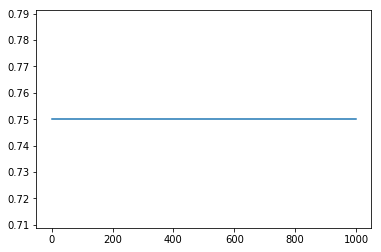

In [24]:
#SVM Fine tunning
cVals = [0.001, 0.10, 0.1, 10, 25, 50, 100, 1000]
f1_scores = []
for c in cVals:
    clf = svm.SVC(gamma='auto',C=c,kernel='rbf')
    clf.fit(X_train,y_train)
    pred = clf.predict(X_test)
    f1_scores.append(f1_score(y_test,pred,average='weighted'))
    
plt.plot(cVals,f1_scores)

#### Output with best parameters for SVM

             precision    recall  f1-score   support

          0       0.00      0.00      0.00        16
          1       0.83      1.00      0.91        77

avg / total       0.69      0.83      0.75        93



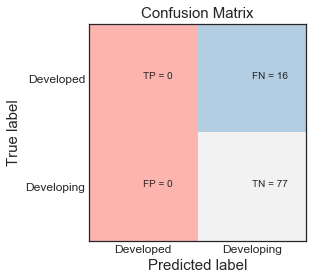

In [25]:
clf = svm.SVC(gamma='auto',C=0.001,kernel='rbf')
clf.fit(X_train,y_train)
pred = clf.predict(X_test)
print(classification_report(y_test,pred))
plotConfusionMatrix(confusion_matrix(y_test,pred))

##### We can see from confusion matrix that SVM does very poor job and recognizes all countries in test set as developing.
##### Recall precision and F1 score for developed countries is 0.00

#### Logistic Regression

             precision    recall  f1-score   support

          0       0.40      0.25      0.31        16
          1       0.86      0.92      0.89        77

avg / total       0.78      0.81      0.79        93



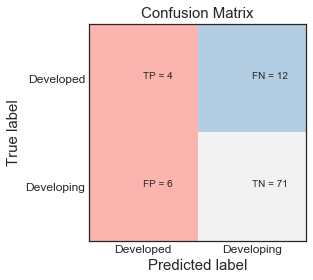

In [26]:
#Logistic Regression
logmodel = LogisticRegression()
logmodel.fit(X_train,y_train)
pred = logmodel.predict(X_test)
print(classification_report(y_test,pred))
plotConfusionMatrix(confusion_matrix(y_test,pred))

###### KNN with k ranging from 1 to 15

Text(0.5,0,'K values')

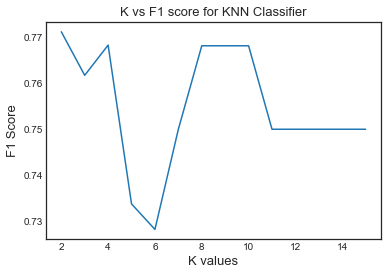

In [27]:
#KNN for different k values
kVals = [2,3,4,5,6,7,8,9,10,11,12,13,14,15]
scores = []

for k in kVals:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train,y_train)
    pred = knn.predict(X_test)
    scores.append(f1_score(y_test,pred,average='weighted'))
    
plt.plot(kVals,scores)
plt.title('K vs F1 score for KNN Classifier',fontsize = 13)
plt.ylabel('F1 Score',fontsize=13)
plt.xlabel('K values',fontsize=13)

#### Output with best value of K

             precision    recall  f1-score   support

          0       0.33      0.31      0.32        16
          1       0.86      0.87      0.86        77

avg / total       0.77      0.77      0.77        93



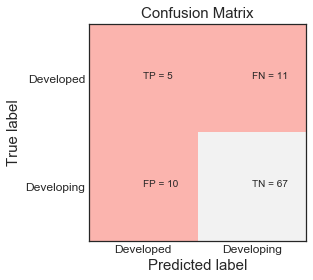

In [28]:
knn = KNeighborsClassifier(n_neighbors=2)
knn.fit(X_train,y_train)
pred = knn.predict(X_test)
print(classification_report(y_test,pred))
plotConfusionMatrix(confusion_matrix(y_test,pred))

#### Decision Tree Classifier

             precision    recall  f1-score   support

          0       0.42      0.31      0.36        16
          1       0.86      0.91      0.89        77

avg / total       0.79      0.81      0.80        93



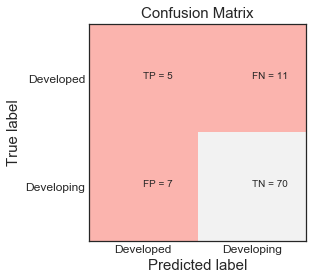

In [29]:
#DT
d_classifier = DecisionTreeClassifier(criterion = 'entropy', random_state = 42)
d_classifier.fit(X_train,y_train)
pred = d_classifier.predict(X_test)
print(classification_report(y_test,pred))
plotConfusionMatrix(confusion_matrix(y_test,pred))

#### Bagging Classifier with Decision Tree as base estimator

[0.7337582898718691, 0.7754224270353303, 0.7971923536439666, 0.7898091762146334, 0.7971923536439666, 0.7971923536439666, 0.7747100367155834, 0.7971923536439666, 0.7971923536439666, 0.7747100367155834, 0.7747100367155834, 0.7747100367155834]


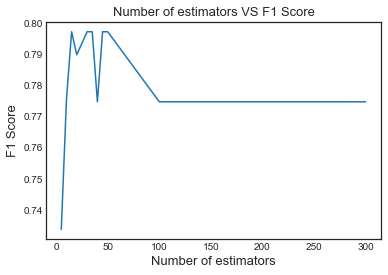

In [30]:
estimators = [5,10,15,20,30,35,40,45,50,100,200,300]
f1_scores = []
for e in estimators:
    cart = DecisionTreeClassifier()
    model = BaggingClassifier(base_estimator=cart, n_estimators=e, random_state=7)
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    f1_scores.append(f1_score(y_test,pred,average='weighted'))
    
plt.plot(estimators,f1_scores) 
plt.title("Number of estimators VS F1 Score",fontsize = 13)
plt.xlabel('Number of estimators',fontsize = 13)
plt.ylabel('F1 Score',fontsize = 13)
print(f1_scores)

             precision    recall  f1-score   support

          0       1.00      0.12      0.22        16
          1       0.85      1.00      0.92        77

avg / total       0.87      0.85      0.80        93



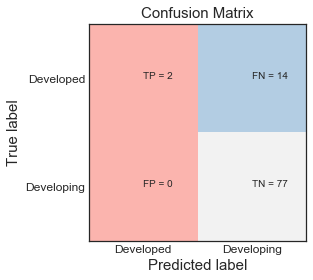

In [32]:
#Bagging Classifier with Decision tree as base learner
cart = DecisionTreeClassifier()
model = BaggingClassifier(base_estimator=cart, n_estimators=50, random_state=7)
model.fit(X_train, y_train)
pred = model.predict(X_test)
print(classification_report(y_test,pred))
plotConfusionMatrix(confusion_matrix(y_test,pred))

#### Random Forest Classifier

#### Fine tuninng Random Forest for different number of estimators

[0.8713134492048733, 0.7971923536439666, 0.7971923536439666, 0.7825625080969039, 0.8097421945847908, 0.7682198327359617, 0.7971923536439666, 0.7971923536439666, 0.7971923536439666, 0.7971923536439666, 0.7971923536439666, 0.7971923536439666]


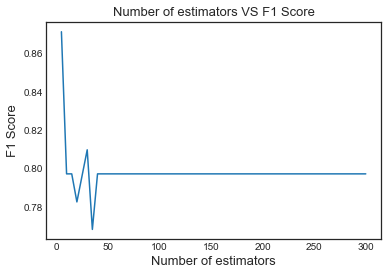

In [33]:
#Ensemble Random Forest Classifier Fine Tunning
estimators = [5,10,15,20,30,35,40,45,50,100,200,300]
f1_scores = []
for e in estimators:
    rf_classifier = RandomForestClassifier(n_estimators=e, random_state = 42)
    rf_classifier.fit(X_train,y_train)
    pred = rf_classifier.predict(X_test)
    f1_scores.append(f1_score(y_test,pred,average='weighted'))
    
plt.plot(estimators,f1_scores) 
plt.title("Number of estimators VS F1 Score",fontsize = 13)
plt.xlabel('Number of estimators',fontsize = 13)
plt.ylabel('F1 Score',fontsize = 13)
print(f1_scores)

#### Lets fine tune for number of features with best number of estimator from above analysis

In [34]:
rf_classifier = RandomForestClassifier(n_estimators=5, random_state = 42)
rf_classifier.fit(X_train,y_train)
pred = rf_classifier.predict(X_test)
print("F1 Score: ", metrics.f1_score(y_test,pred, average='weighted'))
print("Accuracy Score: ", accuracy_score(y_test,pred))

F1 Score:  0.8713134492048733
Accuracy Score:  0.8924731182795699


[0.8198388288868225, 0.7754224270353303, 0.8198388288868225, 0.7898091762146334, 0.7754224270353303, 0.7971923536439666, 0.7898091762146334, 0.7553828216090168, 0.7747100367155834, 0.7825625080969039, 0.7683642085687719]


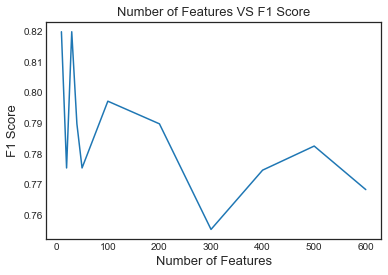

In [36]:
no_of_features = [10,20,30,40,50,100,200,300,400,500,600]
f1_scores = []
for e in no_of_features:
    rf_classifier = RandomForestClassifier(max_features = e ,n_estimators=5,random_state = 42)
    rf_classifier.fit(X_train,y_train)
    pred = rf_classifier.predict(X_test)
    f1_scores.append(f1_score(y_test,pred,average='weighted'))
    
plt.plot(no_of_features,f1_scores)
plt.title("Number of Features VS F1 Score",fontsize = 13)
plt.xlabel('Number of Features',fontsize = 13)
plt.ylabel('F1 Score',fontsize = 13)
print(f1_scores)

#### RFC with Best Parameters

In [37]:
rf_classifier = RandomForestClassifier(n_estimators=5,max_features=10, random_state = 42)
rf_classifier.fit(X_train,y_train)
pred = rf_classifier.predict(X_test)
print("F1 Score: ", metrics.f1_score(y_test,pred, average='weighted'))
print("Accuracy Score: ", accuracy_score(y_test,pred))
print(classification_report(y_test,pred))

F1 Score:  0.8198388288868225
Accuracy Score:  0.8494623655913979
             precision    recall  f1-score   support

          0       0.67      0.25      0.36        16
          1       0.86      0.97      0.91        77

avg / total       0.83      0.85      0.82        93



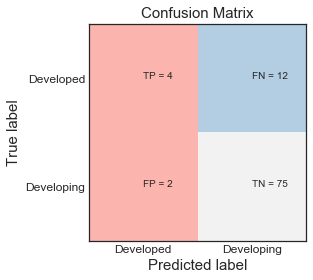

In [38]:
plotConfusionMatrix(confusion_matrix(y_test,pred))

### Extra tree classifier

###### Fine tune for number of estimators

[0.7613671889564816, 0.8018433179723502, 0.8097421945847908, 0.8097421945847908, 0.7898091762146334, 0.7898091762146334, 0.7825625080969039, 0.7825625080969039, 0.7825625080969039, 0.7825625080969039, 0.7898091762146334, 0.7898091762146334]


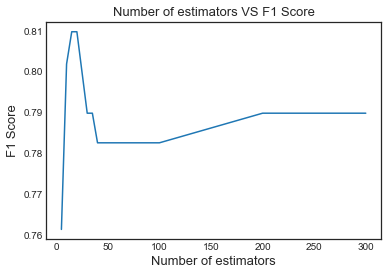

In [39]:
estimators = [5,10,15,20,30,35,40,45,50,100,200,300]
f1_scores = []
for e in estimators:
    model = ExtraTreesClassifier(n_estimators=e,random_state=42)
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    f1_scores.append(f1_score(y_test,pred,average='weighted'))
    
plt.plot(estimators,f1_scores) 
plt.title("Number of estimators VS F1 Score",fontsize = 13)
plt.xlabel('Number of estimators',fontsize = 13)
plt.ylabel('F1 Score',fontsize = 13)
print(f1_scores)

In [41]:
model = ExtraTreesClassifier(n_estimators=10,random_state=42)
model.fit(X_train, y_train)
pred = model.predict(X_test)
print("F1 Score: ", metrics.f1_score(y_test,pred, average='weighted'))
print("Accuracy Score: ", accuracy_score(y_test,pred))

F1 Score:  0.8018433179723502
Accuracy Score:  0.8387096774193549


#### fine tune for max_features

[0.7617837330432515, 0.8018433179723502, 0.8196353436185135, 0.8178346193860156, 0.8035311296960043, 0.7941015187277972, 0.8018433179723502, 0.8280897384840037, 0.8035311296960043, 0.8280897384840037, 0.836724918759698]


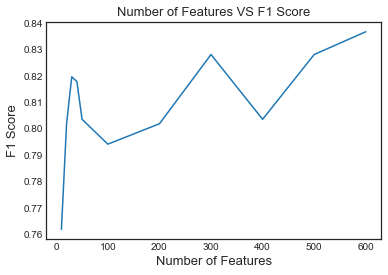

In [42]:
no_of_features = [10,20,30,40,50,100,200,300,400,500,600]
f1_scores = []
for e in no_of_features:
    model = ExtraTreesClassifier(max_features=e,n_estimators=10,random_state=42)
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    f1_scores.append(f1_score(y_test,pred,average='weighted'))
    
plt.plot(no_of_features,f1_scores) 
plt.title("Number of Features VS F1 Score",fontsize = 13)
plt.xlabel('Number of Features',fontsize = 13)
plt.ylabel('F1 Score',fontsize = 13)
print(f1_scores)

#### Best ExtraTree Classifier

In [43]:
model = ExtraTreesClassifier(n_estimators=10,max_features=600,random_state=42)
model.fit(X_train, y_train)
pred = model.predict(X_test)
print("F1 Score: ", metrics.f1_score(y_test,pred, average='weighted'))
print("Accuracy Score: ", accuracy_score(y_test,pred))
print(classification_report(y_test,pred))

F1 Score:  0.836724918759698
Accuracy Score:  0.8602150537634409
             precision    recall  f1-score   support

          0       0.71      0.31      0.43        16
          1       0.87      0.97      0.92        77

avg / total       0.84      0.86      0.84        93



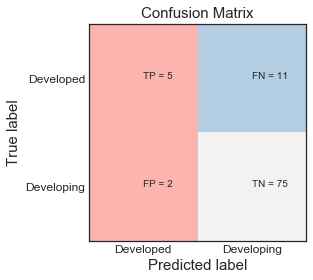

In [44]:
plotConfusionMatrix(confusion_matrix(y_test,pred))

### Treating problem as Unsupervised learning

In [45]:
y = data_after_impute['label']
X = data_after_impute.drop(columns=['id','label'])

### K-Means Clustering

             precision    recall  f1-score   support

          0       0.15      1.00      0.26        35
          1       1.00      0.01      0.01       197

avg / total       0.87      0.16      0.05       232



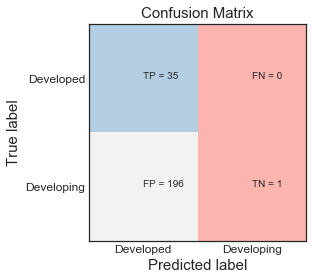

In [46]:
#Build model for k-means clustering
model = KMeans(n_clusters=2,n_init=400,random_state=42,max_iter=1000)
model.fit(X)
y_pred = model.labels_
y_arr = np.array(y)
accuracy_score(y_arr,y_pred)
print(classification_report(y_arr,y_pred))
plotConfusionMatrix(confusion_matrix(y_arr,y_pred))

### Lets do principal component analysis and Singular Value Decomposition

#### First standardize data and then perform PCA

#### Lets plot 2-D graph and check how points are distributed

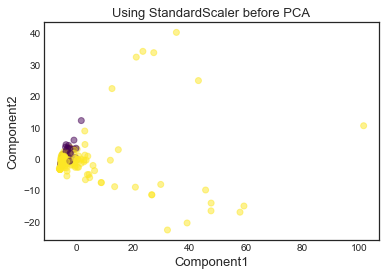

In [47]:
scaler = StandardScaler()
scaled_df = scaler.fit_transform(X)
scaled_df = pd.DataFrame(scaled_df)
pca = PCA(n_components=2)  
X_pca = pca.fit_transform(scaled_df)  
df = pd.DataFrame(X_pca)
df.head()
a = df[0]
b = df [1]
plt.scatter(a,b,alpha=0.5,c=y,cmap='viridis')
plt.title('Using StandardScaler before PCA',fontsize=13)
plt.xlabel('Component1',fontsize=13)
plt.ylabel('Component2',fontsize=13)
plt.show()

#### How does it look in 3D

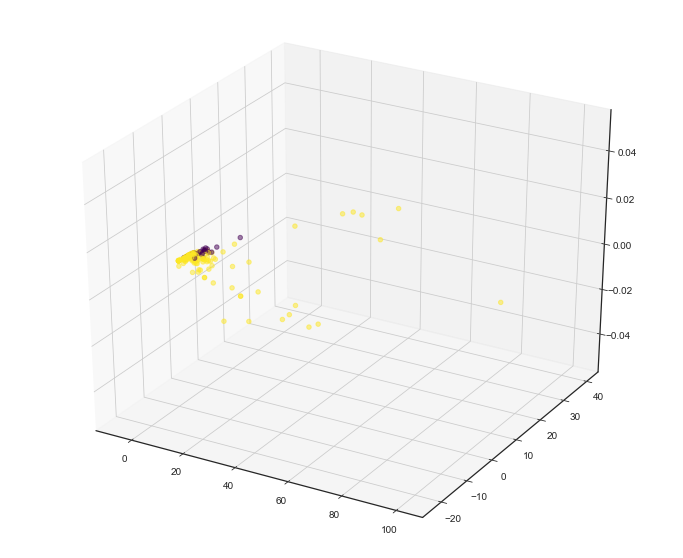

In [48]:
scaler = StandardScaler()
scaled_df = scaler.fit_transform(X)
scaled_df = pd.DataFrame(scaled_df)
pca = PCA(n_components=3)  
X_pca = pca.fit_transform(scaled_df)  
df = pd.DataFrame(X_pca)
df.head()
a = df[0]
b = df [1]
e = df[2]

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(a,b,alpha=0.5,c=y,cmap='viridis')
plt.show()

##  SVD

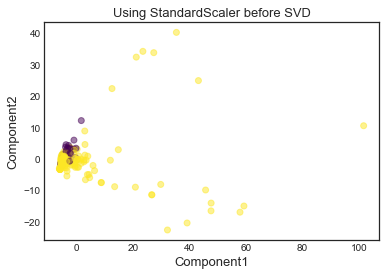

In [49]:
scaler = StandardScaler()
scaled_df = scaler.fit_transform(X)
scaled_df = pd.DataFrame(scaled_df)
pca = TruncatedSVD(n_components=2)  
X_pca = pca.fit_transform(scaled_df)  
df = pd.DataFrame(X_pca)
df.head()
a = df[0]
b = df [1]
plt.scatter(a,b,alpha=0.5,c=y,cmap='viridis')
plt.title('Using StandardScaler before SVD',fontsize=13)
plt.xlabel('Component1',fontsize=13)
plt.ylabel('Component2',fontsize=13)
plt.show()

#### SVD is same as PCA

#### Lets check how data looks if we do min max scaling and then PCA

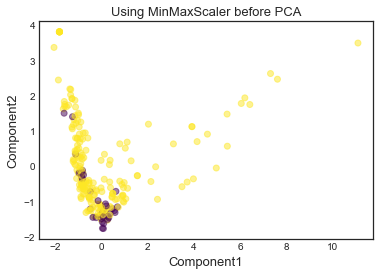

In [50]:
scaler = MinMaxScaler()
scaled_df = scaler.fit_transform(X)
scaled_df = pd.DataFrame(scaled_df)
pca = PCA(n_components=2)  
X_pca = pca.fit_transform(scaled_df)  
df = pd.DataFrame(X_pca)
df.head()
a = df[0]
b = df [1]
plt.scatter(a,b,alpha=0.5,c=y,cmap='viridis')
plt.title('Using MinMaxScaler before PCA',fontsize=13)
plt.xlabel('Component1',fontsize=13)
plt.ylabel('Component2',fontsize=13)
plt.show()

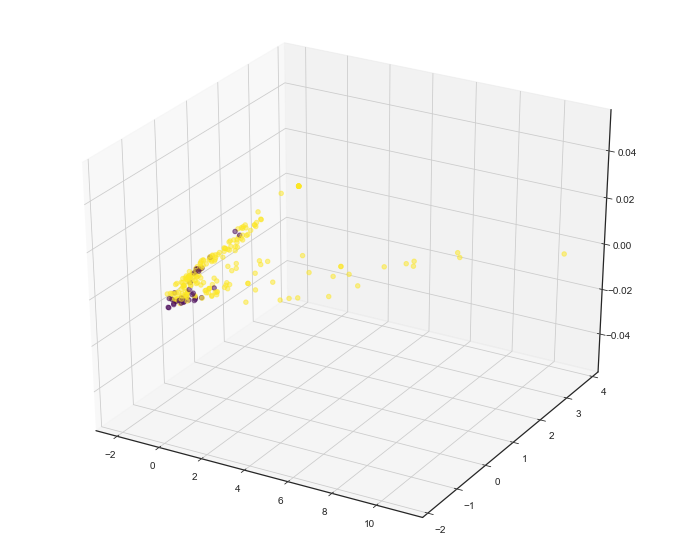

In [51]:
scaler = MinMaxScaler()
scaled_df = scaler.fit_transform(X)
scaled_df = pd.DataFrame(scaled_df)
pca = PCA(n_components=3)  
X_pca = pca.fit_transform(scaled_df)  
df = pd.DataFrame(X_pca)
df.head()
a = df[0]
b = df [1]
e = df[2]

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(a,b,alpha=0.5,c=y,cmap='viridis')
plt.show()

#### SVD with minmaxscaling

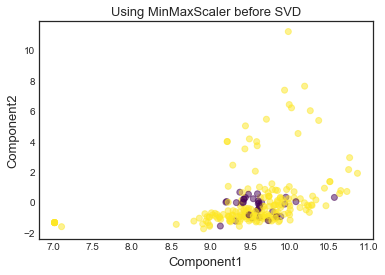

In [52]:
scaler = MinMaxScaler()
scaled_df = scaler.fit_transform(X)
scaled_df = pd.DataFrame(scaled_df)
pca = TruncatedSVD(n_components=2)  
X_pca = pca.fit_transform(scaled_df)  
df = pd.DataFrame(X_pca)
df.head()
a = df[0]
b = df [1]
plt.scatter(a,b,alpha=0.5,c=y,cmap='viridis')
plt.title('Using MinMaxScaler before SVD',fontsize=13)
plt.xlabel('Component1',fontsize=13)
plt.ylabel('Component2',fontsize=13)
plt.show()

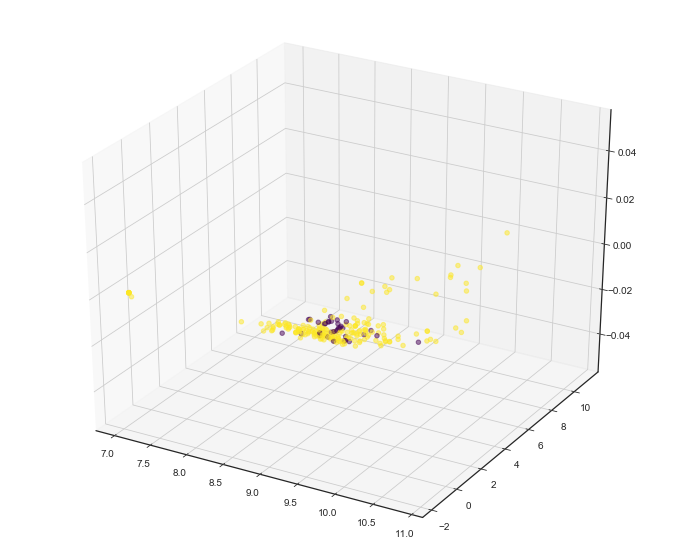

In [53]:
scaler = MinMaxScaler()
scaled_df = scaler.fit_transform(X)
scaled_df = pd.DataFrame(scaled_df)
pca = TruncatedSVD(n_components=3)  
X_pca = pca.fit_transform(scaled_df)  
df = pd.DataFrame(X_pca)
df.head()
a = df[0]
b = df [1]
e = df[2]

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(a,b,alpha=0.5,c=y,cmap='viridis')
plt.show()

In [54]:
#Utility function to perform clustering with different algos, dimensionality reduction, different number of components
def testFunctions(algo,scaling,drTechnique,dimensions,X,y_arr):
    if scaling == 'Standard':
        scaler = StandardScaler()
    elif scaling == 'MinMax':
        scaler = MinMaxScaler()
    scaled_df = scaler.fit_transform(X)
    scaled_df = pd.DataFrame(scaled_df)
    
    if drTechnique == 'PCA':
        pca = PCA(n_components=dimensions)  
        X_pca = pca.fit_transform(scaled_df)
    elif drTechnique == 'SVD':
        pca = TruncatedSVD(n_components=dimensions)  
        X_pca = pca.fit_transform(scaled_df)
        
    if algo == 'KMeans':
        model = KMeans(n_clusters=2,n_init=100,random_state=42,precompute_distances=True,max_iter=1000)
    elif algo == 'AggClustering':
        model = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='ward')
        
    model.fit(X_pca)
    y_pred = model.labels_
    score = f1_score(y_pred,y_arr,average='weighted')
    return score

## K Means

lets check f1 scores for different number of principal components

[0.27112471801482435, 0.27112471801482435, 0.27112471801482435, 0.27112471801482435, 0.27112471801482435, 0.27112471801482435, 0.27112471801482435, 0.27112471801482435, 0.27112471801482435, 0.27112471801482435, 0.8097589554737195, 0.8097589554737195, 0.27112471801482435, 0.8097589554737195, 0.8097589554737195]


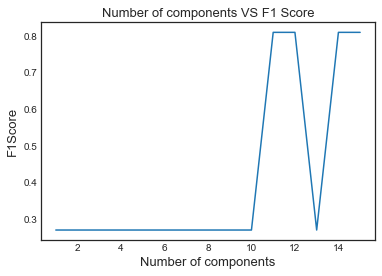

In [55]:
dimensions_ = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
scores = []
for dim in dimensions_:
    scores.append(testFunctions('KMeans','Standard','PCA',dim,X,y_arr))

plt.plot(dimensions_,scores)
plt.title('Number of components VS F1 Score',fontsize = 13)
plt.xlabel("Number of components",fontsize = 13)
plt.ylabel("F1Score",fontsize = 13)
print(scores)

[0.27112471801482435, 0.27112471801482435, 0.27112471801482435, 0.27112471801482435, 0.27112471801482435, 0.27112471801482435, 0.27112471801482435, 0.8097589554737195, 0.8097589554737195, 0.8097589554737195, 0.8097589554737195, 0.8097589554737195, 0.8097589554737195, 0.8097589554737195, 0.8097589554737195]


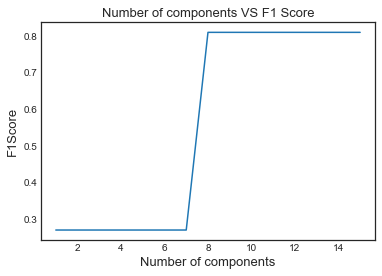

In [56]:
dimensions_ = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
scores = []
for dim in dimensions_:
    scores.append(testFunctions('KMeans','MinMax','PCA',dim,X,y_arr))

plt.plot(dimensions_,scores)
plt.title('Number of components VS F1 Score',fontsize = 13)
plt.xlabel("Number of components",fontsize = 13)
plt.ylabel("F1Score",fontsize = 13)
print(scores)

[0.2647978864005092, 0.2723042933562639, 0.27112471801482435, 0.27112471801482435, 0.8097589554737195, 0.27112471801482435, 0.27112471801482435, 0.8097589554737195, 0.8097589554737195, 0.8097589554737195, 0.8097589554737195, 0.8097589554737195, 0.8097589554737195, 0.8097589554737195, 0.8097589554737195]


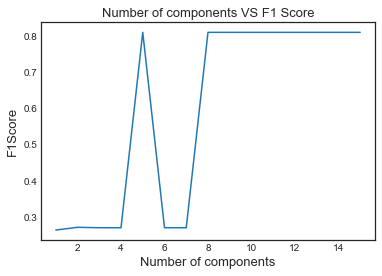

In [57]:
dimensions_ = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
scores = []
for dim in dimensions_:
    scores.append(testFunctions('KMeans','MinMax','SVD',dim,X,y_arr))

plt.plot(dimensions_,scores)
plt.title('Number of components VS F1 Score',fontsize = 13)
plt.xlabel("Number of components",fontsize = 13)
plt.ylabel("F1Score",fontsize = 13)
print(scores)

#### Best results for K Means 

             precision    recall  f1-score   support

          0       0.00      0.00      0.00        35
          1       0.84      0.91      0.87       197

avg / total       0.71      0.78      0.74       232



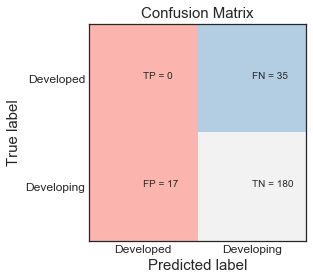

In [58]:
scaler = MinMaxScaler()
scaled_df = scaler.fit_transform(X)
scaled_df = pd.DataFrame(scaled_df)
pca = TruncatedSVD(n_components=10)  
X_pca = pca.fit_transform(scaled_df)
model = KMeans(n_clusters=2,n_init=100,random_state=42,precompute_distances=True,max_iter=1000)
model.fit(X_pca)
y_pred = model.labels_
y_arr = np.array(y)
accuracy_score(y_arr,y_pred)
print(classification_report(y_arr,y_pred))
plotConfusionMatrix(confusion_matrix(y_arr,y_pred))

#### Lets see how did K-Means clustering performed and compare original points vs predicted points

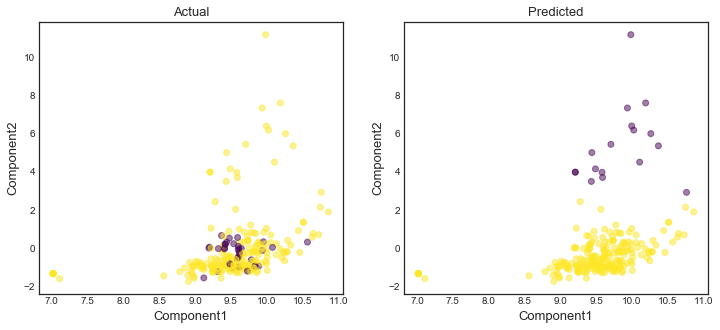

In [60]:
df = pd.DataFrame(X_pca)
df.head()
a = df[0]
b = df [1]
plt.figure(figsize=(12, 5))
plt.subplot(1,2,1)
plt.scatter(a,b,alpha=0.5,c=y,cmap='viridis')
plt.title('Actual',fontsize=13)
plt.xlabel('Component1',fontsize=13)
plt.ylabel('Component2',fontsize=13)

plt.subplot(1,2,2)
plt.scatter(a,b,alpha=0.5,c=y_pred,cmap='viridis')
plt.title('Predicted',fontsize=13)
plt.xlabel('Component1',fontsize=13)
plt.ylabel('Component2',fontsize=13)
plt.show()

## Agglomerative Clustering

[0.7846517917511832, 0.8034650557932712, 0.8034650557932712, 0.8097589554737195, 0.8097589554737195, 0.8097589554737195, 0.8097589554737195, 0.8097589554737195, 0.8034650557932712, 0.8097589554737195, 0.8097589554737195, 0.8097589554737195, 0.8097589554737195, 0.8097589554737195, 0.8097589554737195]


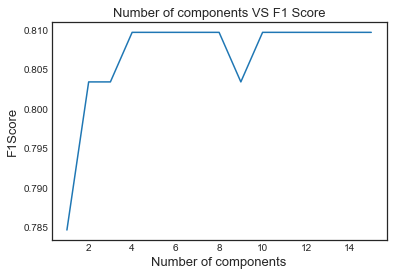

In [61]:
# Standardscaling + PCA
dimensions_ = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
scores = []
for dim in dimensions_:
    scores.append(testFunctions('AggClustering','Standard','PCA',dim,X,y_arr))

plt.plot(dimensions_,scores)
plt.title('Number of components VS F1 Score',fontsize = 13)
plt.xlabel("Number of components",fontsize = 13)
plt.ylabel("F1Score",fontsize = 13)
print(scores)

[0.27112471801482435, 0.27623500847472887, 0.27112471801482435, 0.2723042933562639, 0.2723042933562639, 0.2723042933562639, 0.27112471801482435, 0.2723042933562639, 0.2723042933562639, 0.2723042933562639, 0.2723042933562639, 0.27112471801482435, 0.27112471801482435, 0.2723042933562639, 0.2723042933562639]


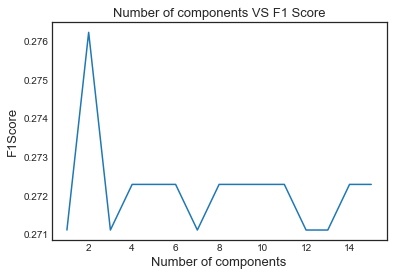

In [62]:
## MinMaxScaling + PCA
dimensions_ = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
scores = []
for dim in dimensions_:
    scores.append(testFunctions('AggClustering','MinMax','PCA',dim,X,y_arr))

plt.plot(dimensions_,scores)
plt.title('Number of components VS F1 Score',fontsize = 13)
plt.xlabel("Number of components",fontsize = 13)
plt.ylabel("F1Score",fontsize = 13)
print(scores)

[0.2647978864005092, 0.2700120676433009, 0.27112471801482435, 0.27112471801482435, 0.27112471801482435, 0.27112471801482435, 0.27112471801482435, 0.27112471801482435, 0.2723042933562639, 0.2723042933562639, 0.2723042933562639, 0.2723042933562639, 0.27112471801482435, 0.27112471801482435, 0.2723042933562639]


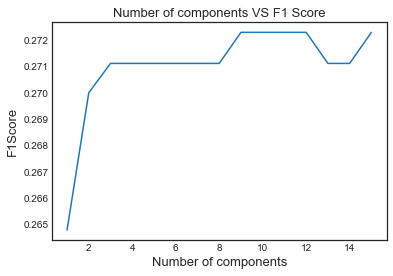

In [63]:
# MinMax Scaling + SVD
dimensions_ = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
scores = []
for dim in dimensions_:
    scores.append(testFunctions('AggClustering','MinMax','SVD',dim,X,y_arr))

plt.plot(dimensions_,scores)
plt.title('Number of components VS F1 Score',fontsize = 13)
plt.xlabel("Number of components",fontsize = 13)
plt.ylabel("F1Score",fontsize = 13)
print(scores)

#### Using best parameters for Agg clustering

             precision    recall  f1-score   support

          0       0.00      0.00      0.00        35
          1       0.84      0.91      0.87       197

avg / total       0.71      0.78      0.74       232



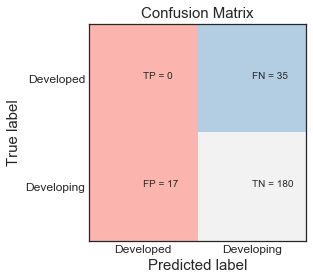

In [64]:
scaler = StandardScaler()
scaled_df = scaler.fit_transform(X)
scaled_df = pd.DataFrame(scaled_df)
pca = PCA(n_components=6)  
X_pca = pca.fit_transform(scaled_df)
model = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='ward')
model.fit(X_pca)
y_pred = model.labels_
y_arr = np.array(y)
accuracy_score(y_arr,y_pred)
print(classification_report(y_arr,y_pred))
plotConfusionMatrix(confusion_matrix(y_arr,y_pred))

#### Lets see how did Agglomerative clustering performed and compare original points vs predicted points

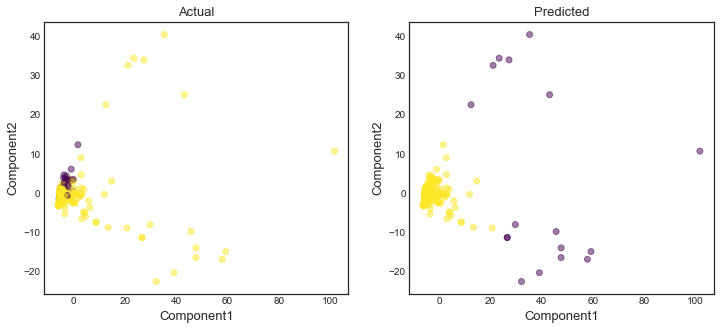

In [65]:
df = pd.DataFrame(X_pca)
df.head()
a = df[0]
b = df [1]
plt.figure(figsize=(12, 5))
plt.subplot(1,2,1)
plt.scatter(a,b,alpha=0.5,c=y,cmap='viridis')
plt.title('Actual',fontsize=13)
plt.xlabel('Component1',fontsize=13)
plt.ylabel('Component2',fontsize=13)

plt.subplot(1,2,2)
plt.scatter(a,b,alpha=0.5,c=y_pred,cmap='viridis')
plt.title('Predicted',fontsize=13)
plt.xlabel('Component1',fontsize=13)
plt.ylabel('Component2',fontsize=13)
plt.show()